### TO DO 
* ~Include account attributes in query~   
* ~Append account attributes to final output~  
* ~revisit original query~ 
* Generate more summary statistics for output  
* Add creation of member network work key tables: individual_id | network ; member_nbr | network  
* Add creation of member network summary table: network | total loans | total savings | number of members | central member
* Fix pdf output  
* Fix regex group error https://stackoverflow.com/questions/39901550/python-userwarning-this-pattern-has-match-groups-to-actually-get-the-groups  
* Add gephx file output

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
#import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

conn = sqlite3.connect('demo_data.db')

In [ ]:
#####################################################
#OLD QUERIES FOR PROOF OF CONCEPT
####################################################

# if using live datamart
t_sql_query = '''
select  a.member_nbr [source], concat((c.first_name + space(1) + c.last_name + space(1)),  a.individual_id) [target] , a.participation_type
from membershipparticipant_today a

--left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

# if using sqlite demo database
sqlite_query = '''
select  
    a.member_nbr [source], 
    c.first_name || ' ' || c.last_name || ' '||  a.individual_id [target] , 
    a.participation_type, b.open_loan_bal

from membershipparticipant_today a

left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

attribute_query = '''
select member_nbr, open_loan_bal
from agr_membertotal_today

'''

In [247]:
####################################################################
# QUERY FOR HANDLING DATA IN PYTHON TO CREATE ATTRIBUTE DICTIONARIES
####################################################################

node_individual_query = '''
SELECT individual_id,  first_name ||' '||last_name [name], open_date 
from individual_today

'''

member_individual_query = '''
SELECT * 
FROM agr_membertotal_today 
'''

edge_query = '''
select member_nbr [source], individual_id [target], participation_type
FROM membershipparticipant_today
'''

In [ ]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

def generate_color_map(graph_object):
    individual_nodes = []
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [76]:
d = pd.read_sql(sqlite_query, conn)
d

NameError: name 'sqlite_query' is not defined

In [260]:
####### REDO QUERY
ind = pd.read_sql(node_individual_query, conn)
mem = pd.read_sql(member_individual_query, conn)
edges= pd.read_sql(edge_query, conn)
#G = nx.from_pandas_edgelist(edges, edge_attr = True)

In [261]:
##THIS WORKS BUT IS IT REDUNDANT
memlist = list(mem['member_nbr'])
indlist = list(ind['individual_id'])
node_list = set(memlist + indlist)

def make_edge_list(edge_df):
    list1 = list(edge_df['source'])
    list2 = list(edge_df['target'])
    edge_list = list(zip(list1, list2))
    return(edge_list)

edge_list = make_edge_list(edges)

mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')

ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

g=nx.Graph()
g.add_nodes_from(indlist)
nx.set_node_attributes(g, ind_dict)

g.add_nodes_from(memlist)
nx.set_node_attributes(g, mem_dict)

g.add_edges_from(edge_list)

list(g.nodes.data())

[(7168, {'name': 'Cole Huerta', 'open_date': '2018-11-02'}),
 (8705, {'name': 'Daisy Rogers', 'open_date': '2012-12-05'}),
 (1538, {'name': 'Layla Floyd', 'open_date': '2005-10-07'}),
 (2053, {'name': 'Amir Oneill', 'open_date': '2008-10-19'}),
 (4619, {'name': 'Melanie Novak', 'open_date': '2015-09-05'}),
 (3598, {'name': 'Liliana Stephenson', 'open_date': '2005-01-07'}),
 (1567, {'name': 'Joseph Oneal', 'open_date': '2015-07-27'}),
 (5668, {'name': 'Piper Shaffer', 'open_date': '2015-09-14'}),
 (5161, {'name': 'Everett Berry', 'open_date': '2007-10-25'}),
 (5180, {'name': 'Nathaniel Barajas', 'open_date': '2015-08-27'}),
 (574, {'name': 'Henry Navarro', 'open_date': '2016-04-22'}),
 (9790, {'name': 'Graham Hunt', 'open_date': '2008-03-06'}),
 (9281, {'name': 'Eliza Stephens', 'open_date': '2011-10-18'}),
 (6725, {'name': 'Kai Richard', 'open_date': '2005-07-14'}),
 (3145, {'name': 'Carlos Valencia', 'open_date': '2014-12-31'}),
 (4172, {'name': 'Tucker Reed', 'open_date': '2002-08-09

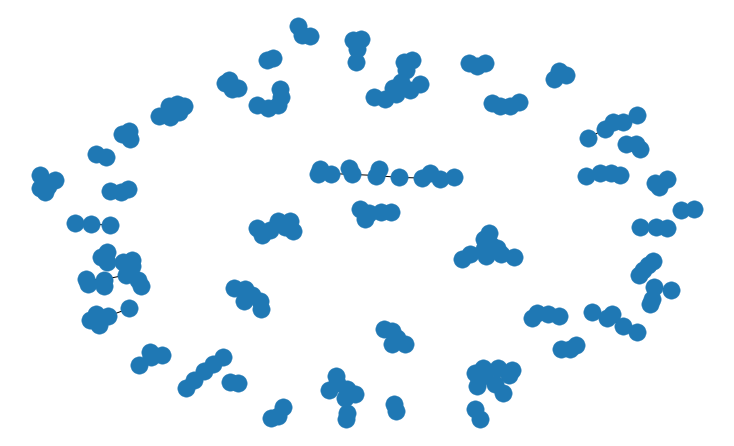

In [262]:
nx.draw(g)

In [264]:
#THIS WORKS TOO USING ONLY ONE PASS WITH ADDING EDGES, SETTING ATTRIBUTES

ind = pd.read_sql(node_individual_query, conn)
mem = pd.read_sql(member_individual_query, conn)
edges= pd.read_sql(edge_query, conn)

memlist = list(mem['member_nbr'])
indlist = list(ind['individual_id'])
node_list = set(memlist + indlist)

def make_edge_list(edge_df):
    list1 = list(edge_df['source'])
    list2 = list(edge_df['target'])
    edge_list = list(zip(list1, list2))
    return(edge_list)

edge_list = make_edge_list(edges)

mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')
ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

mem_dict.update(ind_dict)

g=nx.Graph()
g.add_edges_from(edge_list)
nx.set_node_attributes(g, mem_dict)

list(g.nodes.data())

[(7503,
  {'cls_ln_cnt': 2,
   'cls_sv_cnt': 4,
   'opn_ln_all_cnt': 0,
   'opn_sv_all_cnt': 4,
   'open_loan_bal': 0,
   'open_sv_bal': 218712,
   'div_ytd_amt': 2187.12,
   'int_ytd_amt': 0.0,
   'sv_sd_bal': 107294,
   'sv_sd_cnt': 4,
   'sv_cert_bal': 111418,
   'sv_cert_cnt': 0,
   'max_days_delnq_cnt': 38.0,
   'max_mths_delnq_cnt': 1,
   'wo_ln_cnt': 0,
   'wo_ln_bal': 0}),
 (9960, {'name': 'Oliver Zavala', 'open_date': '2005-11-22'}),
 (3987,
  {'cls_ln_cnt': 2,
   'cls_sv_cnt': 2,
   'opn_ln_all_cnt': 3,
   'opn_sv_all_cnt': 1,
   'open_loan_bal': 1100423,
   'open_sv_bal': 25705,
   'div_ytd_amt': 257.05,
   'int_ytd_amt': 55021.15,
   'sv_sd_bal': 16238,
   'sv_sd_cnt': 1,
   'sv_cert_bal': 9467,
   'sv_cert_cnt': 0,
   'max_days_delnq_cnt': 59.0,
   'max_mths_delnq_cnt': 2,
   'wo_ln_cnt': 0,
   'wo_ln_bal': 0}),
 (8846, {'name': 'Mackenzie Choi', 'open_date': '2006-05-02'}),
 (4924,
  {'cls_ln_cnt': 1,
   'cls_sv_cnt': 3,
   'opn_ln_all_cnt': 2,
   'opn_sv_all_cnt': 2,
   

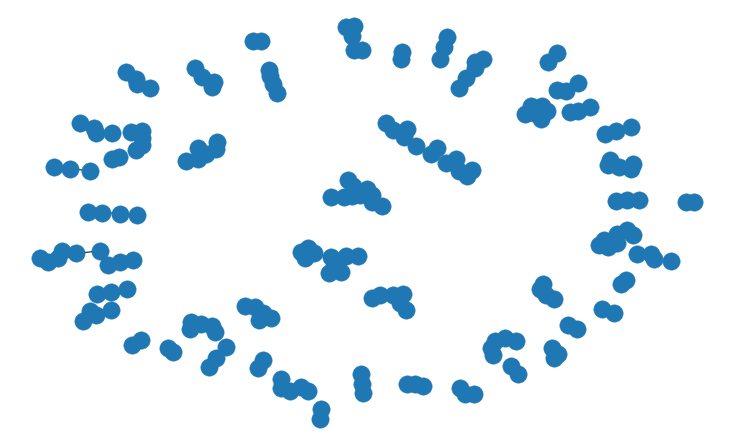

In [266]:
nx.draw(g)

In [271]:
##THIS IS THE SHORTEST - USING FROM_PANDAS_EDGELIST()

ind = pd.read_sql(node_individual_query, conn)
mem = pd.read_sql(member_individual_query, conn)
edges= pd.read_sql(edge_query, conn)

# make attribute dictionaries
mem_dict = mem.set_index('member_nbr')
mem_dict = mem_dict.to_dict('index')
ind_dict = ind.set_index('individual_id')
ind_dict = ind_dict.to_dict('index')

mem_dict.update(ind_dict)

#from pandas edgelist
g = nx.from_pandas_edgelist(edges, edge_attr = True)
nx.set_node_attributes(g, mem_dict)

len(g)

200

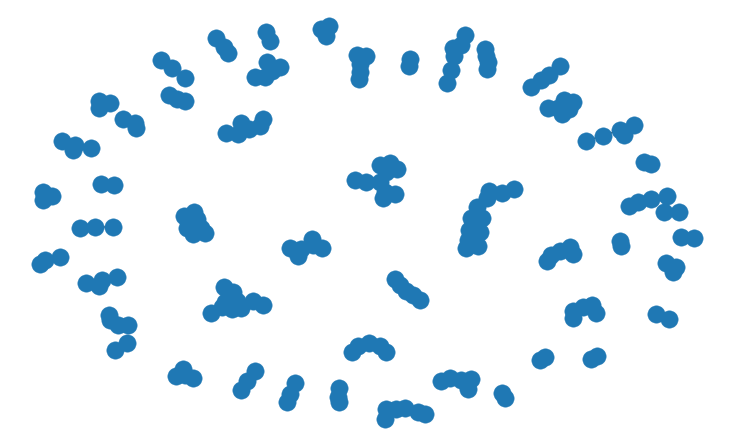

In [270]:
nx.draw(g)

### Basic stats

In [ ]:
G = nx.from_pandas_edgelist(d, edge_attr = True)
print(nx.info(G))
print('connected components: ' +str(nx.number_connected_components(G)))

In [ ]:
# Degrees
degree = nx.degree(G)
degree

In [ ]:
#Degree histogram
plt.rcParams['figure.figsize'] = (10, 6)
degrees = [node[1] for node in degree]
print (degrees)
plt.hist(degrees, bins=10, rwidth=0.9)
plt.show()

In [ ]:
# Show all participants
pos = nx.spring_layout(G)
nx.draw(G, pos=pos,   node_size=1000)
nx.draw_networkx_labels(G, pos=pos )
plt.show()

### Data prep and examining subgraphs

In [ ]:
# make subgraphs from all the connected components within the original dataset
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [ ]:
# node count summary statisitcs of subgraphs
node_count = []
for sub in S:
    count = len(nx.nodes(sub))
    node_count.append(count)
    
print(f'min nodes {min(node_count)}')
print(f'max nodes {max(node_count)}')
print(f'average nodes {sum(node_count)/len(node_count)}')


In [ ]:
# filter for subgraphs with n nodes

n =6 
multi=[]
for sub in S:
    nodes = nx.nodes(sub)
    node_count = len(nodes)
    if node_count>=n:
        multi.append(sub)

print(f'{len(multi)} networks with at least {n} nodes')

In [ ]:
## Code for flattening a subgraph 
#flat_list = [item for sublist in list(multi[0].edges) for item in sublist ]

#degree view
list(multi[0].degree)

#edge view
list(multi[0].edges)

#nodes
list(multi[0].nodes)

In [ ]:
# set colors
source_nodes = list(d['source'])#set([edge[0] for edge in d])
target_nodes = list(d['target'])
for n in G.nodes():
    G.nodes[n]['color'] = 'b' if n in source_nodes else 'o'
colors = [node[1]['color'] for node in G.nodes(data=True)]

In [ ]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

In [ ]:
t = nx.get_edge_attributes(G, 'open_loan_bal')
t

In [ ]:
def get_member_nbr_attributes(attribute_dataframe, node_dataframe):
    attributes = pd.merge(node_dataframe, attribute_dataframe, on = 'member_nbr')
    return(attributes)
    

In [ ]:
def generate_color_map(graph_object):
    individual_nodes = []
    
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [ ]:
#specify subgraph
graph = multi[0]

colors = generate_color_map(graph)

#find center of graph and use it to determine name
center = nx.center(graph)
title = f'the {str(center[0])} network'

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

#layout for display
pos = nx.spring_layout(graph)

#function to separate membership from individuals for display
names,member_nbrs = get_network_members(degrees)

#function to join attributes back on subgraph node
at = get_member_nbr_attributes(attributes,member_nbrs )

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add labels
nx.draw_networkx_labels(graph, pos=pos )
edge_labels = nx.get_edge_attributes(graph, 'participation_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

#Output
print(title)
print(f'{node_count} nodes')
plt.show()
#print(pd.DataFrame.from_dict(nx.degree(graph)))
print(names)
print(at)

In [ ]:
for i in range(10):
    
    graph = multi[i]
    
    individual_nodes = []

    for name in list(graph.nodes):
        if " " in str(name):
            individual_nodes.append(name)

    for n in graph.nodes:
        graph.nodes[n]['color']= 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph.nodes(data=True)]
    
    center = nx.center(graph)
    title = 'The '+str(center[0])+" network"
    degrees = nx.degree(graph)
    node_count = len(nx.nodes(graph))
    pos = nx.spring_layout(graph)
    
    names,member_nbrs = get_network_members(degrees)
    
    nx.draw(graph, pos=pos, node_color=colors,   node_size=1000)

    nx.draw_networkx_labels(graph, pos=pos )
    edge_labels = nx.get_edge_attributes(graph, 'participation_type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    #function to join attributes back on subgraph node
    at = get_member_nbr_attributes(attributes,member_nbrs )
    
    print(title)
    print(str(node_count)+" nodes")
    plt.show()
    #print(pd.DataFrame.from_dict(nx.degree(graph)))
    print(x)
    print(at)
    
    
    fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()